In [ ]:
import pandas as pd

In [1]:
!pip install cebra torch


  Using cached literate_dataclasses-0.0.6-py3-none-any.whl.metadata (2.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.8/251.8 kB 3.8 MB/s eta 0:00:00 0:00:01
Using cached literate_dataclasses-0.0.6-py3-none-any.whl (5.0 kB)


In [ ]:
import pandas as pd
import numpy as np

dat=pd.read_csv('/home/maria/MouseBox/selected_data/models/gpu_working/video_preds/session_view.csv')

# assume your dataframe is called df
# df = pd.read_csv(...) or already loaded

# Extract metadata rows
bodyparts = dat.iloc[0, 1:].values
coords    = dat.iloc[1, 1:].values

# Build column names like Head_x, Head_y, LeftPaw_x, ...
columns = [f"{bp}_{c}" for bp, c in zip(bodyparts, coords)]

# Extract numeric data
X = dat.iloc[2:, 1:].astype(float)
X.columns = columns
X.reset_index(drop=True, inplace=True)

xy_cols = [c for c in X.columns if c.endswith("_x") or c.endswith("_y")]
X_xy = X[xy_cols]

X_xy

X = X_xy.values.reshape(-1, 3, 2)   # (T, keypoints, xy)
X_centered = X - X[:, [2], :]     # subtract Back (index 2)
X_centered = X_centered.reshape(len(X), -1)  # (T, 6)

V = np.diff(X_centered, axis=0, prepend=X_centered[[0]])
X_feat = np.concatenate([X_centered, V], axis=1)  # 12D



In [ ]:
# ============================================================
# CEBRA windowed behavioral embedding from Lightning Pose CSV
# Produces a smooth 3D behavioral trajectory (no sphere collapse)
# ============================================================

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import gaussian_filter1d
from cebra import CEBRA

# ------------------------
# CONFIG
# ------------------------
CSV_PATH = "/home/maria/MouseBox/selected_data/models/gpu_working/video_preds/session_view.csv"

FPS = 30
WINDOW = 20          # frames per window (~0.6s)
STRIDE = 2
TIME_OFFSETS = int(0.7 * FPS)

MAX_ITERS = 6000
BATCH_SIZE = 256
LR = 3e-4
TEMPERATURE = 0.5

SMOOTH_SIGMA = 2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------------
# LOAD LIGHTNING POSE CSV
# ------------------------
print("Loading data...")

dat = pd.read_csv(CSV_PATH)

bodyparts = dat.iloc[0, 1:].values
coords    = dat.iloc[1, 1:].values
columns = [f"{bp}_{c}" for bp, c in zip(bodyparts, coords)]

X = dat.iloc[2:, 1:].astype(float)
X.columns = columns
X.reset_index(drop=True, inplace=True)

xy_cols = [c for c in X.columns if c.endswith("_x") or c.endswith("_y")]
X_xy = X[xy_cols].values

# ------------------------
# PREPROCESS: center + velocity
# ------------------------
X_pose = X_xy.reshape(-1, 3, 2)          # (T, keypoints, xy)
X_centered = X_pose - X_pose[:, [2], :]  # center on Back keypoint
X_centered = X_centered.reshape(len(X_pose), -1)  # (T, 6)

V = np.diff(X_centered, axis=0, prepend=X_centered[[0]])
X_feat = np.concatenate([X_centered, V], axis=1)  # (T, 12)

# ------------------------
# WINDOWING (KEY STEP)
# ------------------------
def make_windows(X, window, stride):
    windows = []
    times = []
    for t in range(0, len(X) - window, stride):
        windows.append(X[t:t + window].reshape(-1))
        times.append(t)
    return np.array(windows), np.array(times)

X_win, t_win = make_windows(X_feat, WINDOW, STRIDE)

print("Windowed data shape:", X_win.shape)

# ------------------------
# NORMALIZE
# ------------------------
scaler = StandardScaler()
X_win = scaler.fit_transform(X_win).astype(np.float32)

# ------------------------
# TRAIN CEBRA
# ------------------------
print("Training CEBRA on", DEVICE)

model = CEBRA(
    model_architecture="offset10-model",
    batch_size=BATCH_SIZE,
    learning_rate=LR,
    temperature=TEMPERATURE,
    output_dimension=3,
    max_iterations=MAX_ITERS,
    distance="euclidean",        # avoids sphere collapse
    conditional="time",
    time_offsets=TIME_OFFSETS,
    device=DEVICE,
    verbose=True,
)

model.fit(X_win, t_win)

# ------------------------
# EMBED + SMOOTH
# ------------------------
Z = model.transform(X_win)
Z = gaussian_filter1d(Z, sigma=SMOOTH_SIGMA, axis=0)

# ------------------------
# PLOT TRAJECTORY
# ------------------------
print("Plotting...")

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")

ax.plot(
    Z[:, 0],
    Z[:, 1],
    Z[:, 2],
    color="black",
    lw=1.5,
    alpha=0.9,
)

sc = ax.scatter(
    Z[:, 0],
    Z[:, 1],
    Z[:, 2],
    c=t_win,
    cmap="viridis",
    s=10,
)

ax.set_title("CEBRA Windowed Behavioral Trajectory")
ax.set_xlabel("CEBRA-1")
ax.set_ylabel("CEBRA-2")
ax.set


In [3]:
import torch
import cebra
from cebra import CEBRA
from sklearn.preprocessing import StandardScaler

# -------------------------
# Basic config
# -------------------------
fps = 30                   # adjust if different
positive_seconds = 0.5     # temporal neighborhood
positive_window = int(fps * positive_seconds)

device = "cuda" if torch.cuda.is_available() else "cpu"

print("Using device:", device)
print("Positive window (frames):", positive_window)

# -------------------------
# Normalize features
# -------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_feat)

# -------------------------
# Time index (CEBRA supervision)
# -------------------------
time_index = np.arange(len(X_scaled))

# -------------------------
# Define CEBRA model
# -------------------------
model = CEBRA(
    model_architecture="offset10-model",   # good default for behavior
    batch_size=512,
    learning_rate=3e-4,
    temperature=1.0,
    output_dimension=3,                     # <-- directly learn 3D
    max_iterations=8000,                    # 3–10k is typical
    distance="cosine",
    conditional="time",                     # time-contrastive
    time_offsets=positive_window,
    device=device,
    verbose=True,
)

# -------------------------
# Train
# -------------------------
model.fit(X_scaled, time_index)

# -------------------------
# Embed all frames
# -------------------------
Z = model.transform(X_scaled)   # (T, 3)

print("Embedding shape:", Z.shape)


Using device: cuda
Positive window (frames): 15


pos: -1.0000 neg:  6.4016 total:  5.4016 temperature:  1.0000: 100%|██████████| 8000/8000 [01:10<00:00, 113.91it/s]


Embedding shape: (900, 3)


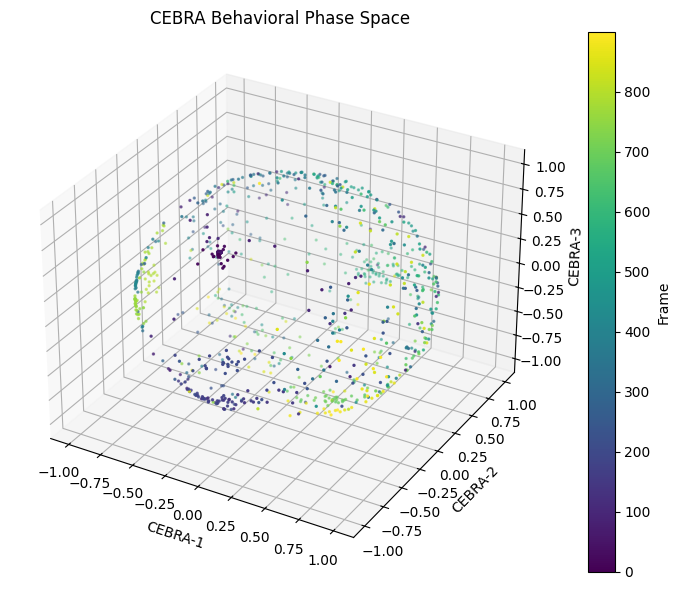

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

t = np.arange(len(Z))

sc = ax.scatter(
    Z[:, 0], Z[:, 1], Z[:, 2],
    c=t,
    cmap="viridis",
    s=2
)

ax.set_title("CEBRA Behavioral Phase Space")
ax.set_xlabel("CEBRA-1")
ax.set_ylabel("CEBRA-2")
ax.set_zlabel("CEBRA-3")

plt.colorbar(sc, label="Frame")
plt.tight_layout()
plt.show()


Loading data...
Windowed data shape: (440, 240)
Training CEBRA on cuda


pos: -0.0000 neg:  3.4632 total:  3.4632 temperature:  0.5000: 100%|██████████| 6000/6000 [00:45<00:00, 130.85it/s]


Plotting...


<bound method Axes3D.set of <Axes3D: title={'center': 'CEBRA Windowed Behavioral Trajectory'}, xlabel='CEBRA-1', ylabel='CEBRA-2'>>

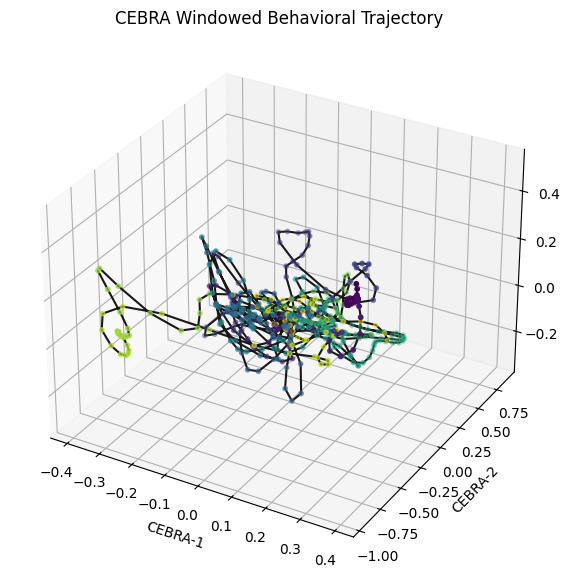

In [5]:
# ============================================================
# CEBRA windowed behavioral embedding from Lightning Pose CSV
# Produces a smooth 3D behavioral trajectory (no sphere collapse)
# ============================================================

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import gaussian_filter1d
from cebra import CEBRA

# ------------------------
# CONFIG
# ------------------------
CSV_PATH = "/home/maria/MouseBox/selected_data/models/gpu_working/video_preds/session_view.csv"

FPS = 30
WINDOW = 20          # frames per window (~0.6s)
STRIDE = 2
TIME_OFFSETS = int(0.7 * FPS)

MAX_ITERS = 6000
BATCH_SIZE = 256
LR = 3e-4
TEMPERATURE = 0.5

SMOOTH_SIGMA = 2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------------
# LOAD LIGHTNING POSE CSV
# ------------------------
print("Loading data...")

dat = pd.read_csv(CSV_PATH)

bodyparts = dat.iloc[0, 1:].values
coords    = dat.iloc[1, 1:].values
columns = [f"{bp}_{c}" for bp, c in zip(bodyparts, coords)]

X = dat.iloc[2:, 1:].astype(float)
X.columns = columns
X.reset_index(drop=True, inplace=True)

xy_cols = [c for c in X.columns if c.endswith("_x") or c.endswith("_y")]
X_xy = X[xy_cols].values

# ------------------------
# PREPROCESS: center + velocity
# ------------------------
X_pose = X_xy.reshape(-1, 3, 2)          # (T, keypoints, xy)
X_centered = X_pose - X_pose[:, [2], :]  # center on Back keypoint
X_centered = X_centered.reshape(len(X_pose), -1)  # (T, 6)

V = np.diff(X_centered, axis=0, prepend=X_centered[[0]])
X_feat = np.concatenate([X_centered, V], axis=1)  # (T, 12)

# ------------------------
# WINDOWING (KEY STEP)
# ------------------------
def make_windows(X, window, stride):
    windows = []
    times = []
    for t in range(0, len(X) - window, stride):
        windows.append(X[t:t + window].reshape(-1))
        times.append(t)
    return np.array(windows), np.array(times)

X_win, t_win = make_windows(X_feat, WINDOW, STRIDE)

print("Windowed data shape:", X_win.shape)

# ------------------------
# NORMALIZE
# ------------------------
scaler = StandardScaler()
X_win = scaler.fit_transform(X_win).astype(np.float32)

# ------------------------
# TRAIN CEBRA
# ------------------------
print("Training CEBRA on", DEVICE)

model = CEBRA(
    model_architecture="offset10-model",
    batch_size=BATCH_SIZE,
    learning_rate=LR,
    temperature=TEMPERATURE,
    output_dimension=3,
    max_iterations=MAX_ITERS,
    distance="euclidean",        # avoids sphere collapse
    conditional="time",
    time_offsets=TIME_OFFSETS,
    device=DEVICE,
    verbose=True,
)

model.fit(X_win, t_win)

# ------------------------
# EMBED + SMOOTH
# ------------------------
Z = model.transform(X_win)
Z = gaussian_filter1d(Z, sigma=SMOOTH_SIGMA, axis=0)

# ------------------------
# PLOT TRAJECTORY
# ------------------------
print("Plotting...")

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")

ax.plot(
    Z[:, 0],
    Z[:, 1],
    Z[:, 2],
    color="black",
    lw=1.5,
    alpha=0.9,
)

sc = ax.scatter(
    Z[:, 0],
    Z[:, 1],
    Z[:, 2],
    c=t_win,
    cmap="viridis",
    s=10,
)

ax.set_title("CEBRA Windowed Behavioral Trajectory")
ax.set_xlabel("CEBRA-1")
ax.set_ylabel("CEBRA-2")
ax.set


Loading data...
Windowed data shape: (440, 240)
Training CEBRA on cuda


pos: -0.0000 neg:  3.4651 total:  3.4651 temperature:  0.5000: 100%|██████████| 6000/6000 [00:42<00:00, 141.82it/s]


Plotting...


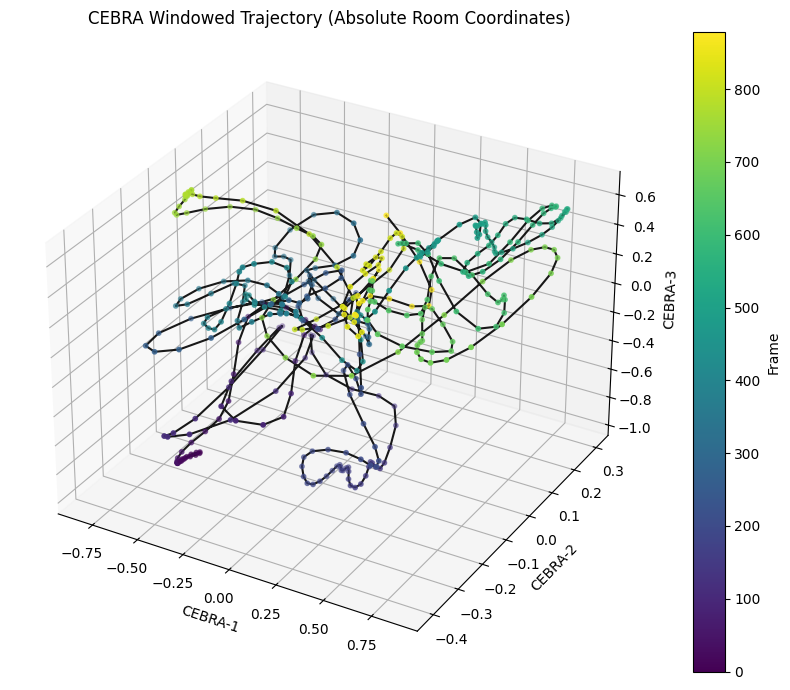

Done.


In [6]:
# ============================================================
# CEBRA windowed embedding WITHOUT normalization or centering
# Embedding reflects absolute position in fixed room
# ============================================================

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter1d
from cebra import CEBRA

# ------------------------
# CONFIG
# ------------------------
CSV_PATH = "/home/maria/MouseBox/selected_data/models/gpu_working/video_preds/session_view.csv"

FPS = 30
WINDOW = 20
STRIDE = 2
TIME_OFFSETS = int(0.7 * FPS)

MAX_ITERS = 6000
BATCH_SIZE = 256
LR = 3e-4
TEMPERATURE = 0.5

SMOOTH_SIGMA = 2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------------
# LOAD LIGHTNING POSE CSV
# ------------------------
print("Loading data...")

dat = pd.read_csv(CSV_PATH)

bodyparts = dat.iloc[0, 1:].values
coords    = dat.iloc[1, 1:].values
columns = [f"{bp}_{c}" for bp, c in zip(bodyparts, coords)]

X = dat.iloc[2:, 1:].astype(float)
X.columns = columns
X.reset_index(drop=True, inplace=True)

xy_cols = [c for c in X.columns if c.endswith("_x") or c.endswith("_y")]
X_xy = X[xy_cols].values.astype(np.float32)

# ------------------------
# PREPROCESS: ABSOLUTE POSITION + VELOCITY (NO CENTERING)
# ------------------------
X_pose = X_xy.reshape(-1, 3, 2)          # (T, keypoints, xy)
X_flat = X_pose.reshape(len(X_pose), -1)  # (T, 6) absolute coords

V = np.diff(X_flat, axis=0, prepend=X_flat[[0]])
X_feat = np.concatenate([X_flat, V], axis=1)  # (T, 12)

# ------------------------
# WINDOWING
# ------------------------
def make_windows(X, window, stride):
    windows = []
    times = []
    for t in range(0, len(X) - window, stride):
        windows.append(X[t:t + window].reshape(-1))
        times.append(t)
    return np.array(windows, dtype=np.float32), np.array(times)

X_win, t_win = make_windows(X_feat, WINDOW, STRIDE)

print("Windowed data shape:", X_win.shape)

# ------------------------
# TRAIN CEBRA (NO NORMALIZATION)
# ------------------------
print("Training CEBRA on", DEVICE)

model = CEBRA(
    model_architecture="offset10-model",
    batch_size=BATCH_SIZE,
    learning_rate=LR,
    temperature=TEMPERATURE,
    output_dimension=3,
    max_iterations=MAX_ITERS,
    distance="euclidean",
    conditional="time",
    time_offsets=TIME_OFFSETS,
    device=DEVICE,
    verbose=True,
)

model.fit(X_win, t_win)

# ------------------------
# EMBED + SMOOTH
# ------------------------
Z = model.transform(X_win)
Z = gaussian_filter1d(Z, sigma=SMOOTH_SIGMA, axis=0)

# ------------------------
# PLOT TRAJECTORY
# ------------------------
print("Plotting...")

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")

ax.plot(
    Z[:, 0],
    Z[:, 1],
    Z[:, 2],
    color="black",
    lw=1.5,
    alpha=0.9,
)

sc = ax.scatter(
    Z[:, 0],
    Z[:, 1],
    Z[:, 2],
    c=t_win,
    cmap="viridis",
    s=10,
)

ax.set_title("CEBRA Windowed Trajectory (Absolute Room Coordinates)")
ax.set_xlabel("CEBRA-1")
ax.set_ylabel("CEBRA-2")
ax.set_zlabel("CEBRA-3")

plt.colorbar(sc, label="Frame")
plt.tight_layout()
plt.show()

print("Done.")
